##Выполнил ДЗ Крайнов Максим, ML-21

<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [1]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [4]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("image_codes.npy")
captions = json.load(open('captions_tokenized.json'))

CPU times: user 199 ms, sys: 857 ms, total: 1.06 s
Wall time: 1.06 s



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [5]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [6]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [7]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for img in captions:
  for caption in img:
    if isinstance(caption, str):
      tokens = caption.lower().split()
    else:
      tokens = [w.lower() for w in caption]
    word_counts.update(tokens)

In [8]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [9]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [10]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   26,  264,  142,    7,  161,   16,   26,  860,  157,   13,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   26,  264,   55,   20,   26,  860,  157,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   26,  264,   43,   20,  905,   37,  622,  157,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   47,  117,  264,   43,   55,   20,  622, 1527,   79,   13,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   26,  264,   55,   20,   26,  860,  125,   60,   47,  278,
        3643,   26, 3644,   37,   47, 1130,   13,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]

        h0 = initial_hid.unsqueeze(0)
        c0 = initial_cell.unsqueeze(0)
        lstm_out, _ = self.lstm(captions_emb, (h0, c0))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [14]:
network = CaptionNet(n_tokens)

In [15]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10405])


In [18]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    B, T, V = logits_for_next.shape
    logits_flat = logits_for_next.view(B * T, V)
    targets_flat = captions_ix_next.view(B * T)

    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=pad_ix)

    return loss.unsqueeze(0)

In [19]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [20]:
import torch.optim as optim

optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [22]:
from sklearn.model_selection import train_test_split

train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [25]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = [captions[i] for i in random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = [choice(caps) for caps in captions_for_batch_images]

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [28]:
generate_batch(img_codes, captions, 3)

(tensor([[0.0518, 0.0968, 0.6681,  ..., 0.2100, 0.1956, 0.0258],
         [0.2416, 0.5247, 0.6158,  ..., 0.0787, 1.2748, 0.7630],
         [0.1609, 0.1456, 0.5280,  ..., 0.5259, 0.6943, 0.5194]]),
 tensor([[   1,   26,  219,  143,   60,   26, 2509,   17,  473,    2,    3,    3],
         [   1,  193,    7,    8,  902,  687,  183,  891,  969,    2,    3,    3],
         [   1,   90, 1705,  326,   20,   26,  133,   73,  681, 1625,   13,    2]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [27]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [29]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()

        torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=5.0)
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 0, train loss: 9.04910551071167, val loss: 8.701156044006348


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]



Epoch: 1, train loss: 8.213776922225952, val loss: 7.691238498687744


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]



Epoch: 2, train loss: 7.083750238418579, val loss: 6.379967880249024


100%|██████████| 50/50 [00:30<00:00,  1.67it/s]



Epoch: 3, train loss: 6.149300575256348, val loss: 6.035261249542236


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]



Epoch: 4, train loss: 5.801756887435913, val loss: 5.6568018913269045


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



Epoch: 5, train loss: 5.57157338142395, val loss: 5.476266860961914


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]



Epoch: 6, train loss: 5.344290800094605, val loss: 5.2443318367004395


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]



Epoch: 7, train loss: 5.198993530273437, val loss: 5.116906929016113


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]



Epoch: 8, train loss: 5.125914392471313, val loss: 5.008354568481446


100%|██████████| 50/50 [00:25<00:00,  2.00it/s]



Epoch: 9, train loss: 5.011255292892456, val loss: 4.957216072082519


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]



Epoch: 10, train loss: 4.949080238342285, val loss: 4.937569808959961


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]



Epoch: 11, train loss: 4.863508682250977, val loss: 4.834149169921875


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 12, train loss: 4.816394872665406, val loss: 4.8068592071533205


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



Epoch: 13, train loss: 4.797859449386596, val loss: 4.787096881866455


100%|██████████| 50/50 [00:29<00:00,  1.72it/s]



Epoch: 14, train loss: 4.749875755310058, val loss: 4.730902862548828


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 15, train loss: 4.675518980026245, val loss: 4.755960178375244


100%|██████████| 50/50 [00:26<00:00,  1.92it/s]



Epoch: 16, train loss: 4.660258169174194, val loss: 4.502528285980224


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



Epoch: 17, train loss: 4.6429696369171145, val loss: 4.607217693328858


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]



Epoch: 18, train loss: 4.5934912109375, val loss: 4.5475465774536135


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]



Epoch: 19, train loss: 4.614400997161865, val loss: 4.593433570861817


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]



Epoch: 20, train loss: 4.534012041091919, val loss: 4.4649029731750485


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 21, train loss: 4.500275278091431, val loss: 4.489975357055664


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]



Epoch: 22, train loss: 4.499347658157348, val loss: 4.508902931213379


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]



Epoch: 23, train loss: 4.458126716613769, val loss: 4.484327793121338


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]



Epoch: 24, train loss: 4.468356304168701, val loss: 4.485455894470215


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 25, train loss: 4.417787189483643, val loss: 4.41968183517456


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]



Epoch: 26, train loss: 4.428430547714234, val loss: 4.457173633575439


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]



Epoch: 27, train loss: 4.378029479980468, val loss: 4.449038887023926


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]



Epoch: 28, train loss: 4.3785153579711915, val loss: 4.333345031738281


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]



Epoch: 29, train loss: 4.3624278259277345, val loss: 4.3255819320678714


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 30, train loss: 4.359038772583008, val loss: 4.3801881790161135


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



Epoch: 31, train loss: 4.3368341588974, val loss: 4.404561614990234


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]



Epoch: 32, train loss: 4.339920659065246, val loss: 4.394130611419678


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 33, train loss: 4.302841882705689, val loss: 4.275538349151612


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]



Epoch: 34, train loss: 4.32113639831543, val loss: 4.315445423126221


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]



Epoch: 35, train loss: 4.26807580947876, val loss: 4.388489246368408


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 36, train loss: 4.26376932144165, val loss: 4.247914791107178


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]



Epoch: 37, train loss: 4.288066444396972, val loss: 4.1913200378417965


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]



Epoch: 38, train loss: 4.232116222381592, val loss: 4.285158348083496


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]



Epoch: 39, train loss: 4.233323264122009, val loss: 4.21253662109375


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



Epoch: 40, train loss: 4.249793014526367, val loss: 4.120398616790771


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 41, train loss: 4.208517098426819, val loss: 4.270134544372558


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]



Epoch: 42, train loss: 4.172824440002441, val loss: 4.169841384887695


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 43, train loss: 4.173696093559265, val loss: 4.12985577583313


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]



Epoch: 44, train loss: 4.174020414352417, val loss: 4.164827442169189


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]



Epoch: 45, train loss: 4.214456958770752, val loss: 4.173000288009644


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]



Epoch: 46, train loss: 4.1900030136108395, val loss: 4.103070640563965


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 47, train loss: 4.130526580810547, val loss: 4.2138134956359865


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]



Epoch: 48, train loss: 4.155855102539062, val loss: 4.2102532386779785


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]



Epoch: 49, train loss: 4.157745070457459, val loss: 4.243262672424317


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]



Epoch: 50, train loss: 4.093443670272827, val loss: 4.202357482910156


100%|██████████| 50/50 [00:26<00:00,  1.85it/s]



Epoch: 51, train loss: 4.109797058105468, val loss: 4.078393650054932


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]



Epoch: 52, train loss: 4.109359912872314, val loss: 4.114081382751465


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]



Epoch: 53, train loss: 4.079191517829895, val loss: 4.093403387069702


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]



Epoch: 54, train loss: 4.070583162307739, val loss: 3.988266706466675


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]



Epoch: 55, train loss: 4.065781846046447, val loss: 4.020683002471924


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]



Epoch: 56, train loss: 4.04999436378479, val loss: 3.929208755493164


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]



Epoch: 57, train loss: 4.011804475784301, val loss: 4.02694263458252


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]



Epoch: 58, train loss: 4.045856218338013, val loss: 4.148869132995605


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]



Epoch: 59, train loss: 4.037035298347473, val loss: 4.021295404434204


100%|██████████| 50/50 [00:29<00:00,  1.72it/s]



Epoch: 60, train loss: 4.0251959657669065, val loss: 4.047059822082519


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]



Epoch: 61, train loss: 4.010581221580505, val loss: 4.040856552124024


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]



Epoch: 62, train loss: 3.9914305210113525, val loss: 3.9909040451049806


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]



Epoch: 63, train loss: 4.008007516860962, val loss: 4.026402425765991


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]



Epoch: 64, train loss: 3.9791039705276487, val loss: 3.943465805053711


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 65, train loss: 3.9861208772659302, val loss: 3.895231819152832


100%|██████████| 50/50 [00:26<00:00,  1.85it/s]



Epoch: 66, train loss: 3.935136423110962, val loss: 3.9107075691223145


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]



Epoch: 67, train loss: 3.945658631324768, val loss: 3.9937579154968263


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]



Epoch: 68, train loss: 3.957358922958374, val loss: 4.074570989608764


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]



Epoch: 69, train loss: 3.9459022760391234, val loss: 3.889208364486694


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]



Epoch: 70, train loss: 3.957440447807312, val loss: 3.9387248516082765


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 71, train loss: 3.889164147377014, val loss: 4.083159065246582


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]



Epoch: 72, train loss: 3.8886031675338746, val loss: 3.803183937072754


100%|██████████| 50/50 [00:30<00:00,  1.61it/s]



Epoch: 73, train loss: 3.905006141662598, val loss: 3.962189960479736


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]



Epoch: 74, train loss: 3.8879750871658327, val loss: 3.9345204830169678


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]



Epoch: 75, train loss: 3.880351505279541, val loss: 3.735662412643433


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]



Epoch: 76, train loss: 3.88754855632782, val loss: 3.883103847503662


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]



Epoch: 77, train loss: 3.863520612716675, val loss: 3.843839645385742


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



Epoch: 78, train loss: 3.8369886541366576, val loss: 3.917448949813843


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]



Epoch: 79, train loss: 3.862077417373657, val loss: 3.7344195365905763


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]



Epoch: 80, train loss: 3.842425489425659, val loss: 3.8545267581939697


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]



Epoch: 81, train loss: 3.840010194778442, val loss: 3.869623613357544


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]



Epoch: 82, train loss: 3.866577968597412, val loss: 3.7126067638397218


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]



Epoch: 83, train loss: 3.7862083196640013, val loss: 3.7728670120239256


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]



Epoch: 84, train loss: 3.8387202262878417, val loss: 3.775204133987427


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]



Epoch: 85, train loss: 3.825853691101074, val loss: 3.9240062713623045


100%|██████████| 50/50 [00:30<00:00,  1.67it/s]



Epoch: 86, train loss: 3.8138947248458863, val loss: 3.7681250095367433


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]



Epoch: 87, train loss: 3.807545852661133, val loss: 3.96341290473938


100%|██████████| 50/50 [00:28<00:00,  1.75it/s]



Epoch: 88, train loss: 3.8191139364242552, val loss: 3.931348752975464


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]



Epoch: 89, train loss: 3.777052240371704, val loss: 3.764214038848877


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]



Epoch: 90, train loss: 3.81553644657135, val loss: 3.759792184829712


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]



Epoch: 91, train loss: 3.7644258403778075, val loss: 3.7719958782196046


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]



Epoch: 92, train loss: 3.7277293825149536, val loss: 3.7894642829895018


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 93, train loss: 3.823534789085388, val loss: 3.7774778842926025


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]



Epoch: 94, train loss: 3.7539104413986206, val loss: 3.879477691650391


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]



Epoch: 95, train loss: 3.7448354005813598, val loss: 3.763578462600708


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]



Epoch: 96, train loss: 3.7293888092041017, val loss: 3.7006016254425047


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]



Epoch: 97, train loss: 3.7396628570556643, val loss: 3.685596799850464


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]



Epoch: 98, train loss: 3.7589740467071535, val loss: 3.66206636428833


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]



Epoch: 99, train loss: 3.7384615468978883, val loss: 3.762989902496338
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [30]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|██████████| 104M/104M [00:00<00:00, 255MB/s] 


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [31]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [41]:
from matplotlib import pyplot as plt
from PIL import Image
import os
%matplotlib inline

os.makedirs("data", exist_ok=True)
#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg

img = Image.open('data/img.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 22:39:24--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-29 22:39:24--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.008s  

2025-10-29 22:39:25 (6.33 MB/s) - ‘data/img.jpg’ saved [54731/547

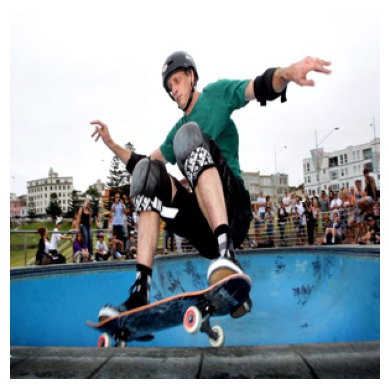

In [36]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [38]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a woman is on a tennis court in a field .
a man is holding a tennis ball on a tennis court .
a man is holding a tennis ball
a man is standing on a tennis court .
a man is holding a tennis ball with a tennis ball .
a man is holding a tennis court .
a man is holding a tennis ball on a tennis court .
a man is holding a tennis court .
a man is standing on a tennis court .
a man is standing on a skateboard in a field .


### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

In [44]:
# apply your network on images you've found
#
#
!wget https://s13.stc.all.kpcdn.net/family/wp-content/uploads/2022/10/top-kak-podruzhit-koshku-i-sobaku-960h540.jpg -O data/img2.jpg
img = Image.open('data/img2.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.


--2025-10-29 22:45:30--  https://s13.stc.all.kpcdn.net/family/wp-content/uploads/2022/10/top-kak-podruzhit-koshku-i-sobaku-960h540.jpg
Resolving s13.stc.all.kpcdn.net (s13.stc.all.kpcdn.net)... 188.72.103.3
Connecting to s13.stc.all.kpcdn.net (s13.stc.all.kpcdn.net)|188.72.103.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249432 (244K) [image/jpeg]
Saving to: ‘data/img2.jpg’

data/img2.jpg       100%[===================>] 243.59K   350KB/s    in 0.7s    

2025-10-29 22:45:32 (350 KB/s) - ‘data/img2.jpg’ saved [249432/249432]



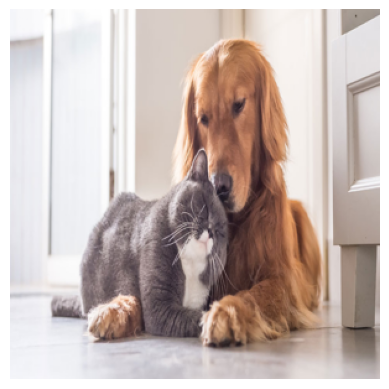

In [45]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [46]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a cat sitting on a table with a window .
a dog is sitting on a table with a window .
a cat sitting on a bed with a window .
a cat is sitting on a table with a laptop .
a cat sitting on a table with a window .
a cat sitting on a table with a laptop .
a cat is sitting on a table with a toilet .
a cat is sitting on a table in a room .
a dog is sitting on a table with a laptop .
a black and white cat sitting on a table .


In [48]:
!wget https://cdn5.vedomosti.ru/image/2023/9f/14htul/original-1ghd.jpg -O data/img3.jpg
img = Image.open('data/img3.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 22:55:58--  https://cdn5.vedomosti.ru/image/2023/9f/14htul/original-1ghd.jpg
Resolving cdn5.vedomosti.ru (cdn5.vedomosti.ru)... 188.72.103.3
Connecting to cdn5.vedomosti.ru (cdn5.vedomosti.ru)|188.72.103.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418516 (409K) [image/jpeg]
Saving to: ‘data/img3.jpg’

data/img3.jpg       100%[===================>] 408.71K   566KB/s    in 0.7s    

2025-10-29 22:56:00 (566 KB/s) - ‘data/img3.jpg’ saved [418516/418516]



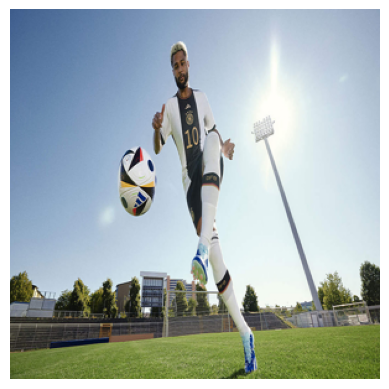

In [49]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [50]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man is standing on a tennis court .
a man is standing in a field with a baseball game .
a man is standing on a tennis court .
a man is standing on a skateboard in a field .
a man is standing in a field with a baseball game .
a man is standing on a tennis court .
a man is standing in a field with a baseball game .
a man is standing in a field with a tennis ball .
a man in a baseball player with a tennis ball .
a man is standing on a tennis court .


In [56]:
!wget https://upload.wikimedia.org/wikipedia/commons/8/83/Chef_at_Jimmy%27s_World_Grill_%26_Bar.jpg -O data/img4.jpg
img = Image.open('data/img4.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:02:21--  https://upload.wikimedia.org/wikipedia/commons/8/83/Chef_at_Jimmy%27s_World_Grill_%26_Bar.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315092 (308K) [image/jpeg]
Saving to: ‘data/img4.jpg’

data/img4.jpg       100%[===================>] 307.71K  --.-KB/s    in 0.08s   

2025-10-29 23:02:21 (3.61 MB/s) - ‘data/img4.jpg’ saved [315092/315092]



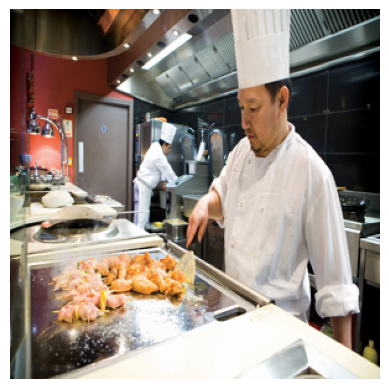

In [52]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [53]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man with a white and a pizza on a table .
a man is sitting on a table .
a woman is sitting on a table with a table .
a man is sitting on a table with a plate .
a man is sitting on a table with a table .
a man is sitting on a table with a table .
a man is sitting on a table with a table .
a man is sitting on a table with a table .
a man is sitting on a table with a table .
a woman and a pizza sitting on a table .


In [68]:
!wget https://zoopark44.ru/i/p/19b.jpg -O data/img5.jpg
img = Image.open('data/img5.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:07:07--  https://zoopark44.ru/i/p/19b.jpg
Resolving zoopark44.ru (zoopark44.ru)... 92.38.255.22
Connecting to zoopark44.ru (zoopark44.ru)|92.38.255.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76920 (75K) [image/jpeg]
Saving to: ‘data/img5.jpg’

data/img5.jpg       100%[===================>]  75.12K   223KB/s    in 0.3s    

2025-10-29 23:07:08 (223 KB/s) - ‘data/img5.jpg’ saved [76920/76920]



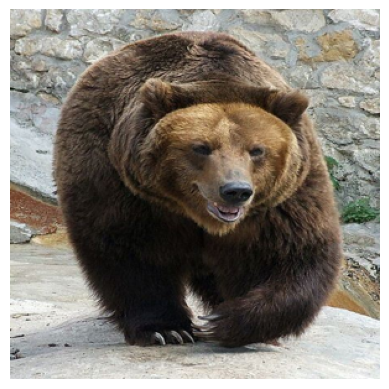

In [69]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [70]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a white and white dog on a beach .
a small bear is standing on the side of a street .
a white dog sitting on a bench .
a black and white dog standing in the grass .
a white and white white and a white dog .
a small dog is sitting on a street .
a large white and white dog on a field .
a white and white dog on a field .
a white dog on a skateboard with a building .
a white dog is sitting on a bench .


In [73]:
!wget https://habrastorage.org/getpro/geektimes/post_images/d02/6a8/862/d026a8862f3cc4560f35ee0b9edc1f00.jpg -O data/img6.jpg
img = Image.open('data/img6.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:10:12--  https://habrastorage.org/getpro/geektimes/post_images/d02/6a8/862/d026a8862f3cc4560f35ee0b9edc1f00.jpg
Resolving habrastorage.org (habrastorage.org)... 95.47.173.35, 95.47.173.34, 2a14:b680:0:56::34, ...
Connecting to habrastorage.org (habrastorage.org)|95.47.173.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98250 (96K) [image/jpeg]
Saving to: ‘data/img6.jpg’

data/img6.jpg       100%[===================>]  95.95K   453KB/s    in 0.2s    

2025-10-29 23:10:13 (453 KB/s) - ‘data/img6.jpg’ saved [98250/98250]



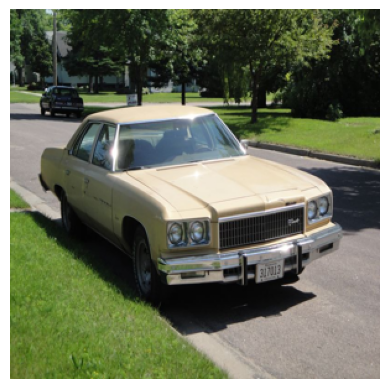

a white and white and white white and a clock on the side of a building .
a large clock with a clock on the street .
a large white train with a clock on the street .
a white and white white and a white and a building .
a white bus is on a street with a clock .
a large clock on a street with a building .
a large truck is sitting on a street .
a white and white and white white and a white building .
a white and white that is on a street .
a white and white bus on a street .


In [74]:
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [75]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/The_Sun_by_the_Atmospheric_Imaging_Assembly_of_NASA%27s_Solar_Dynamics_Observatory_-_20100819.jpg/330px-The_Sun_by_the_Atmospheric_Imaging_Assembly_of_NASA%27s_Solar_Dynamics_Observatory_-_20100819.jpg -O data/img7.jpg
img = Image.open('data/img7.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:13:35--  https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/The_Sun_by_the_Atmospheric_Imaging_Assembly_of_NASA%27s_Solar_Dynamics_Observatory_-_20100819.jpg/330px-The_Sun_by_the_Atmospheric_Imaging_Assembly_of_NASA%27s_Solar_Dynamics_Observatory_-_20100819.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35673 (35K) [image/jpeg]
Saving to: ‘data/img7.jpg’

data/img7.jpg       100%[===================>]  34.84K  --.-KB/s    in 0.02s   

2025-10-29 23:13:35 (1.59 MB/s) - ‘data/img7.jpg’ saved [35673/35673]



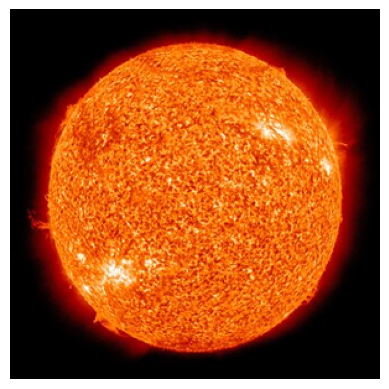

a person on a white and a blue and a building .
a large white and white and white and a white plate
a black and white white and white and white and white .
a large white and white white and a white plate
a small bear is on a street .
a large white and white and white and white
a white and white and white white and a white .
a white and white and white and a white
a white and white and white and white and a dog .
a large white and white and a white plate


In [76]:
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [77]:
!wget https://sobakovod.club/uploads/posts/2021-12/1638509767_1-sobakovod-club-p-sobaki-poroda-sobak-belogo-tsveta-i-pushis-1.jpg -O data/img8.jpg
img = Image.open('data/img8.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:16:02--  https://sobakovod.club/uploads/posts/2021-12/1638509767_1-sobakovod-club-p-sobaki-poroda-sobak-belogo-tsveta-i-pushis-1.jpg
Resolving sobakovod.club (sobakovod.club)... 185.183.32.23
Connecting to sobakovod.club (sobakovod.club)|185.183.32.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232782 (227K) [image/jpeg]
Saving to: ‘data/img8.jpg’

data/img8.jpg       100%[===================>] 227.33K   489KB/s    in 0.5s    

2025-10-29 23:16:03 (489 KB/s) - ‘data/img8.jpg’ saved [232782/232782]



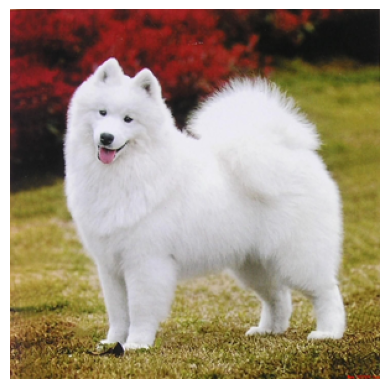

a group of people standing on a table .
a large white dog with a white and a white
a large white and white dog sitting on a table .
a white and white dog on a field .
a group of people standing on a field .
a giraffe is standing on a field .
a white and white cat sitting on a table .
a large dog is standing on a table .
a large white and white dog on a field .
a group of people standing on a field .


In [78]:
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [81]:
!wget https://s6.stc.all.kpcdn.net/family/wp-content/uploads/2024/06/otkrytoki-s-dnem-semi-lyubvi-i-vernosti-960.jpg -O data/img9.jpg
img = Image.open('data/img9.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:21:24--  https://s6.stc.all.kpcdn.net/family/wp-content/uploads/2024/06/otkrytoki-s-dnem-semi-lyubvi-i-vernosti-960.jpg
Resolving s6.stc.all.kpcdn.net (s6.stc.all.kpcdn.net)... 188.72.103.3
Connecting to s6.stc.all.kpcdn.net (s6.stc.all.kpcdn.net)|188.72.103.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287315 (281K) [image/jpeg]
Saving to: ‘data/img9.jpg’

data/img9.jpg       100%[===================>] 280.58K   439KB/s    in 0.6s    

2025-10-29 23:21:26 (439 KB/s) - ‘data/img9.jpg’ saved [287315/287315]



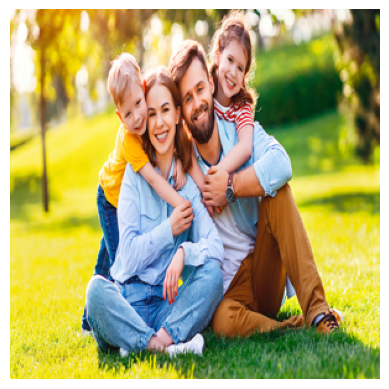

a woman is holding a skateboard on a table .
a woman holding a tennis on a tennis court .
a man is holding a skateboard on a table .
a woman in a kitchen with a tennis and a woman .
a woman is holding a tennis ball on a skateboard .
a man is holding a tennis game in a kitchen .
a young boy is holding a tennis game .
a woman is holding a tennis court in a room .
a woman holding a tennis game on a tennis ball .
a young boy is holding a tennis game .


In [82]:
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [83]:
!wget https://olymps.ru/wp-content/uploads/2025/03/basketball-2.webp -O data/img10.jpg
img = Image.open('data/img10.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:25:34--  https://olymps.ru/wp-content/uploads/2025/03/basketball-2.webp
Resolving olymps.ru (olymps.ru)... 45.130.41.26
Connecting to olymps.ru (olymps.ru)|45.130.41.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93872 (92K) [image/webp]
Saving to: ‘data/img10.jpg’

data/img10.jpg      100%[===================>]  91.67K   237KB/s    in 0.4s    

2025-10-29 23:25:36 (237 KB/s) - ‘data/img10.jpg’ saved [93872/93872]



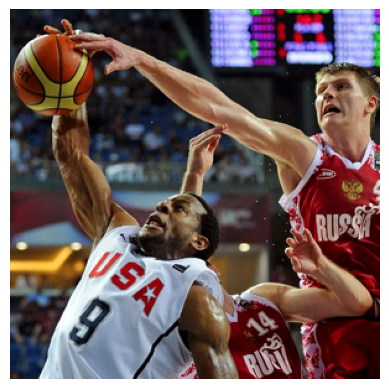

a man is standing in the snow .
a man is standing in a field .
a group of people standing on a field .
a man is standing on a skateboard .
a group of people standing on a field .
a man is standing in a field .
a man is standing on a field .
a man standing on a skateboard with a skateboard .
a man is standing on a skateboard .
a man is standing on a skateboard .


In [84]:
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

In [85]:
!wget https://habrastorage.org/getpro/habr/post_images/3db/ac4/5df/3dbac45df51c33b0bd63621081afbe29.jpg -O data/img11.jpg
img = Image.open('data/img11.jpg').resize((299, 299))
img = np.asarray(img).astype('float32') / 255.

--2025-10-29 23:28:49--  https://habrastorage.org/getpro/habr/post_images/3db/ac4/5df/3dbac45df51c33b0bd63621081afbe29.jpg
Resolving habrastorage.org (habrastorage.org)... 95.47.173.34, 95.47.173.35, 2a14:b680:0:56::34, ...
Connecting to habrastorage.org (habrastorage.org)|95.47.173.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74582 (73K) [image/jpeg]
Saving to: ‘data/img11.jpg’

data/img11.jpg      100%[===================>]  72.83K   421KB/s    in 0.2s    

2025-10-29 23:28:51 (421 KB/s) - ‘data/img11.jpg’ saved [74582/74582]



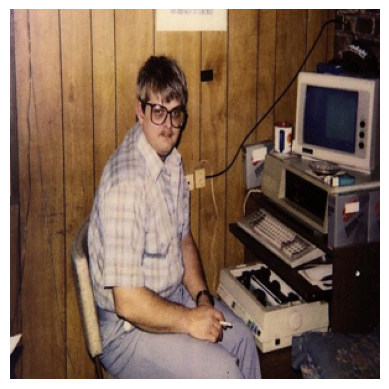

a man is holding a skateboard on a table .
a man on a skateboard on a table .
a man holding a skateboard in a kitchen .
a woman is holding a laptop on a table .
a woman is sitting on a table with a laptop .
a man and a woman sitting on a table .
a man is sitting on a table with a table .
a man in a bathroom with a woman and a laptop .
a man is holding a skateboard on a table .
a man is holding a skateboard in a room .


In [86]:
plt.imshow(img)
plt.axis('off')
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
